# NPS Project

In [1]:
from nba_api.stats.endpoints import leaguegamefinder, playercareerstats
from nba_api.stats.static import players

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

ModuleNotFoundError: No module named 'nba_api'

#### Test for Nikola Jokić's stats (player_id = '203999')

In [26]:
NikoJokic = playercareerstats.PlayerCareerStats(player_id='203999')
jokic_df = NikoJokic.get_data_frames()[0]
print(jokic_df)

    PLAYER_ID SEASON_ID LEAGUE_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  \
0      203999   2015-16        00  1610612743               DEN        21.0   
1      203999   2016-17        00  1610612743               DEN        22.0   
2      203999   2017-18        00  1610612743               DEN        23.0   
3      203999   2018-19        00  1610612743               DEN        24.0   
4      203999   2019-20        00  1610612743               DEN        25.0   
5      203999   2020-21        00  1610612743               DEN        26.0   
6      203999   2021-22        00  1610612743               DEN        27.0   
7      203999   2022-23        00  1610612743               DEN        28.0   
8      203999   2023-24        00  1610612743               DEN        29.0   
9      203999   2024-25        00  1610612743               DEN        30.0   
10     203999   2025-26        00  1610612743               DEN        30.0   

    GP  GS   MIN  FGM  ...  FT_PCT  OREB  DREB   RE

#### List of all NBA players

We want to take all the players who started their career after the 2000-01 Season (included)

In [27]:
nba_players = players.get_players()
print(nba_players[:5])

[{'id': 76001, 'full_name': 'Alaa Abdelnaby', 'first_name': 'Alaa', 'last_name': 'Abdelnaby', 'is_active': False}, {'id': 76002, 'full_name': 'Zaid Abdul-Aziz', 'first_name': 'Zaid', 'last_name': 'Abdul-Aziz', 'is_active': False}, {'id': 76003, 'full_name': 'Kareem Abdul-Jabbar', 'first_name': 'Kareem', 'last_name': 'Abdul-Jabbar', 'is_active': False}, {'id': 51, 'full_name': 'Mahmoud Abdul-Rauf', 'first_name': 'Mahmoud', 'last_name': 'Abdul-Rauf', 'is_active': False}, {'id': 1505, 'full_name': 'Tariq Abdul-Wahad', 'first_name': 'Tariq', 'last_name': 'Abdul-Wahad', 'is_active': False}]


##### Transformation of the players salaries and salary cap CSVs in pandas DataFrames

In [5]:
sal_df = pd.read_csv('data/Salaries.csv', delimiter=';') 
sal_df['Season'] = sal_df['Season'].apply(lambda x: f"{x-1}-{str(x)[-2:]}")
print(sal_df[sal_df["Season"] == "2024-25"].head(20))


cap_df = pd.read_csv('data/salary_cap.csv', delimiter=';')
print("\n", cap_df)

                      Player    Salary   Season
11869          Stephen Curry  55761216  2024-25
11870            Joel Embiid  51415938  2024-25
11871           Nikola Jokic  51415938  2024-25
11872           Kevin Durant  51179021  2024-25
11873           Bradley Beal  50203930  2024-25
11874           Jaylen Brown  49205800  2024-25
11875           Devin Booker  49205800  2024-25
11876     Karl-Anthony Towns  49205800  2024-25
11877            Paul George  49205800  2024-25
11878          Kawhi Leonard  49205800  2024-25
11879           Jimmy Butler  48798677  2024-25
11880  Giannis Antetokounmpo  48787676  2024-25
11881         Damian Lillard  48787676  2024-25
11882           LeBron James  48728845  2024-25
11883            Zach LaVine  44531940  2024-25
11884            Rudy Gobert  43827586  2024-25
11885          Anthony Davis  43219440  2024-25
11886            Luka Doncic  43031940  2024-25
11887             Trae Young  43031940  2024-25
11888          Fred VanVleet  42846615  

##### Joining salary cap and salaries DataFrames on column 'Season'

In [6]:
sal_cap_df = sal_df.merge(cap_df, on='Season', how='left')
sal_cap_df = sal_cap_df[sal_cap_df["Season"] != "1999-00"]
sal_cap_df["ratio_cap"] = sal_cap_df["Salary"] / sal_cap_df["SalaryCapUSD"]
sal_cap_df = sal_cap_df.rename(columns={"Season": "SEASON_ID"})
sal_cap_df["Season"] = sal_cap_df["SEASON_ID"].astype(str)
print(sal_cap_df[sal_cap_df["Season"] == "2024-25"].head(20))
print(sal_cap_df["Season"].dtype)

                      Player    Salary SEASON_ID  SalaryCapUSD  ratio_cap  \
11869          Stephen Curry  55761216   2024-25   140588000.0   0.396629   
11870            Joel Embiid  51415938   2024-25   140588000.0   0.365721   
11871           Nikola Jokic  51415938   2024-25   140588000.0   0.365721   
11872           Kevin Durant  51179021   2024-25   140588000.0   0.364035   
11873           Bradley Beal  50203930   2024-25   140588000.0   0.357100   
11874           Jaylen Brown  49205800   2024-25   140588000.0   0.350000   
11875           Devin Booker  49205800   2024-25   140588000.0   0.350000   
11876     Karl-Anthony Towns  49205800   2024-25   140588000.0   0.350000   
11877            Paul George  49205800   2024-25   140588000.0   0.350000   
11878          Kawhi Leonard  49205800   2024-25   140588000.0   0.350000   
11879           Jimmy Butler  48798677   2024-25   140588000.0   0.347104   
11880  Giannis Antetokounmpo  48787676   2024-25   140588000.0   0.347026   

### Transformation of all 25 csv containing players' stats into DataFrames

Taking off the "Player 1" column which is the same as Player column. 

Taking off the 2025-26 season because these season is not over. Taking an uncomplete season into accoutn could disrupt the measures

For players who got transfered from one team to another during a given season season, we take off the lines describing the stats of the players with one team and the other. It allows us to keep only the line that contains the stats for the whole season (team abbreviation is "TOT").

In [7]:
for i in range(25):
    if i < 10:
        var_name = f"stats_df_0{i}"
    else:
        var_name = f"stats_df_{i}"
    globals()[var_name] = pd.read_csv(f'data/nba_players{i}.csv')
    globals()[var_name].drop(columns=['Player.1'], inplace=True) #Il y a une deuxième colonne nom qui apparaît, je ne sais pas pourquoi. Je peux donc la drop
    globals()[var_name] = globals()[var_name][globals()[var_name]['SEASON_ID'] != '2025-26'] #On drop la saison 2025-26 dans chaque df parce qu'elle est incomplète
    list_drop = []
    mask = (~globals()[var_name].duplicated(subset=['Player', 'SEASON_ID'], keep=False)| (globals()[var_name]['TEAM_ABBREVIATION'] == 'TOT'))
    globals()[var_name] = globals()[var_name][mask].reset_index(drop=True)
    globals()[var_name] = globals()[var_name].sort_values(['Player','SEASON_ID']).reset_index(drop=True)
    for j in range(len(globals()[var_name]) - 1):
        if globals()[var_name]['GP'][j] < 30 :
            list_drop.append(j)
    globals()[var_name].drop(index=list_drop).reset_index(drop=True)   
    if 'Unnamed: 0' in globals()[var_name].columns:
        globals()[var_name].drop(columns=['Unnamed: 0'], inplace=True) #On drop la colonne Unnamed: 0 qui apparaît à la lecture du csv
        

print(stats_df_09.columns)
print(stats_df_09.head(20))

Index(['Player', 'SEASON_ID', 'PPG', 'RPG', 'APG', 'BPG', 'SPG',
       'TEAM_ABBREVIATION', 'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FG_PCT',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'TOVPG', 'PFPG', 'FG3MPG', 'FG3APG',
       'FGMPG', 'FGAPG', 'OREBPG'],
      dtype='object')
             Player SEASON_ID    PPG   RPG   APG   BPG   SPG  \
0        AJ Hammons   2016-17   2.18  1.64  0.18  0.59  0.05   
1    Aaron Harrison   2015-16   0.86  0.71  0.10  0.00  0.29   
2    Aaron Harrison   2016-17   0.20  0.60  0.60  0.00  0.00   
3    Aaron Harrison   2017-18   6.67  2.67  1.22  0.22  1.00   
4   Adam Harrington   2002-03   1.58  0.42  0.63  0.05  0.11   
5   Andrew Harrison   2016-17   5.90  1.89  2.75  0.29  0.74   
6   Andrew Harrison   2017-18   9.52  2.34  3.16  0.46  0.68   
7   Andrew Harrison   2018-19   3.18  1.18  1.41  0.12  0.24   
8    Ben Handlogten   2003-04   4.00  3.24  0.35  0.24  0.18   
9    Ben Handlogten   2004-05   4.52  3.10  0.62  0.24  0.33   
10   Ben Hansbrough   2

Checking for missing values in the DataFrame. We count the number of zeros in each numeric column. Zeros in PPG, RPG, APG, GP, FG_PCT, FTA, FTM, PFPG indicate that the player has not played (or played barely at all). Such players cannot be included in the model because these zeros reflect a clear lack of data on the player.
 

In [8]:
for i in range(25):
    if i < 10 : 
        var_name = f"stats_df_0{i}"
    else:
        var_name = f"stats_df_{i}"
    #print(globals()[var_name].isna().sum())
    #print(globals()[var_name][globals()[var_name].isna().any(axis=1)])

    #On compte le nombre de zéros dans chaque colonne numérique. Des zéros en PPG, RPG, APG, GP, FG_PCT, FTA, FTM, PFPG montrent que le joueur n'a pas ou à peine joué. On ne peut pas l'inclure dans le modèle car ces zéros représentent un manque flagrant d'absence de données sur le joueur
    colonnes_critiques = ["PPG", "RPG", "APG", "GP", "FG_PCT", "FTA", "FTM", "PFPG"]
    globals()[var_name] = globals()[var_name][~(globals()[var_name][colonnes_critiques] == 0).any(axis=1)] #On enlève les lignes qui contiennt un 0 parmi une des "stats critiques"
    #for col in colonnes_critiques:
        #if globals()[var_name][col].dtype in ['float64', 'int64']:
            #print(f"{col}: { (globals()[var_name][col] == 0).sum() } zéros")
            

#### Merging the 25 Dataframes into 1

In [9]:
liste_stats_df = [globals()[f"stats_df_0{i}"] for i in range(10)]+[globals()[f"stats_df_{i}"] for i in range(10, 25)]
stats_all_df = pd.concat(liste_stats_df, ignore_index=True)
print(f"We have {len(stats_all_df)} seasons of NBA players after cleaning the dataset")  


We have 9402 seasons of NBA players after cleaning the dataset


#### Merging the two DataFrames (full_df)

In [10]:
# Merge X et Y

full_df = stats_all_df.merge(sal_cap_df[["Player","SEASON_ID","ratio_cap"]], on=["Player","SEASON_ID"], how='inner')
print(full_df.head(20))


             Player SEASON_ID    PPG   RPG   APG   BPG   SPG  \
0   Al-Farouq Aminu   2010-11   5.64  3.30  0.74  0.31  0.73   
1   Al-Farouq Aminu   2011-12   6.05  4.67  1.00  0.52  0.89   
2   Al-Farouq Aminu   2012-13   7.30  7.70  1.36  0.67  1.21   
3   Al-Farouq Aminu   2013-14   7.15  6.20  1.42  0.48  1.02   
4   Al-Farouq Aminu   2014-15   5.57  4.62  0.80  0.84  0.95   
5   Al-Farouq Aminu   2015-16  10.23  6.09  1.68  0.65  0.88   
6   Al-Farouq Aminu   2016-17   8.72  7.39  1.62  0.72  0.98   
7   Al-Farouq Aminu   2017-18   9.33  7.61  1.22  0.58  1.14   
8   Al-Farouq Aminu   2018-19   9.38  7.53  1.28  0.41  0.84   
9   Al-Farouq Aminu   2019-20   4.33  4.83  1.17  0.44  1.00   
10  Al-Farouq Aminu   2020-21   4.43  4.78  1.35  0.39  0.83   
11    Alan Anderson   2005-06   5.75  1.94  0.89  0.11  0.31   
12    Alan Anderson   2006-07   5.76  1.88  1.24  0.00  0.41   
13    Alan Anderson   2011-12   9.59  2.00  1.53  0.18  0.29   
14    Alan Anderson   2012-13  10.66  2.

#### Plot of several statistics to have a better idea of what they look like

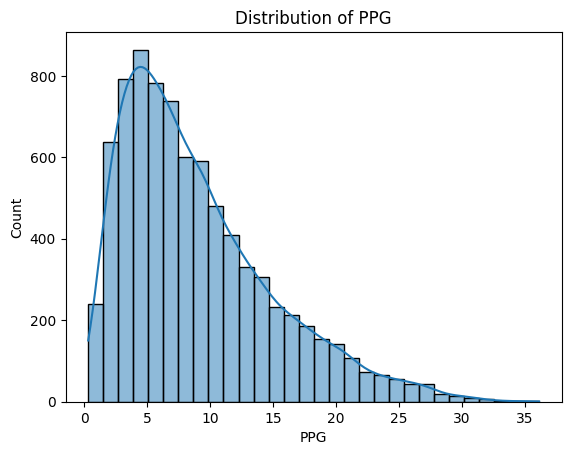

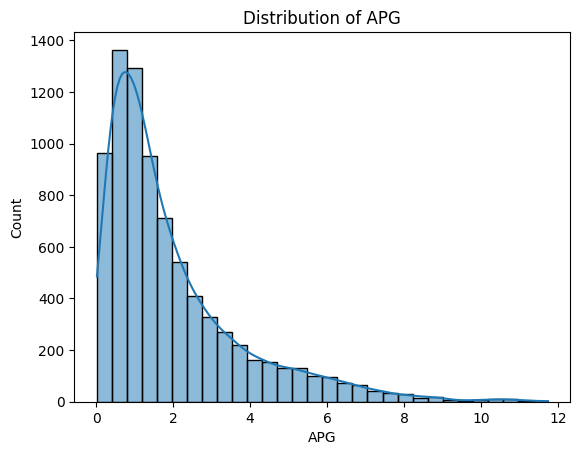

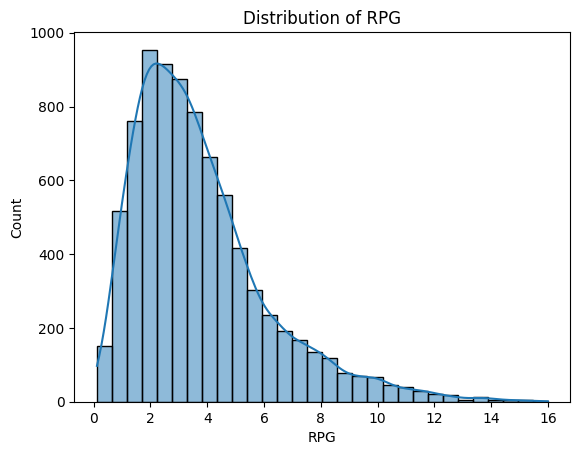

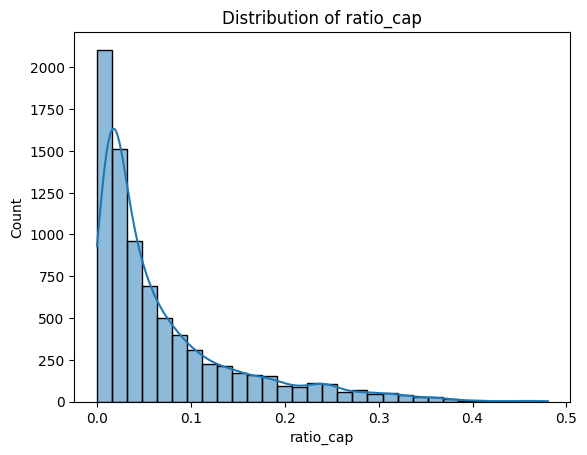

In [11]:
stats = ['PPG', 'APG', 'RPG', "ratio_cap"]
for stat in stats:
    sns.histplot(full_df[stat], kde=True, bins=30)
    plt.title(f"Distribution of {stat}")
    plt.show()

#### Statistical study of the DataFrame : descriptive statistics eand 95% confidence interval

In [12]:
y = full_df['ratio_cap']

# Descriptive statistics
print(y.describe())  # count, mean, std, min, quartiles, max [web:547][web:543]

# 95 % Confidence interval
mean = y.mean()
std = y.std(ddof=1)
n = y.count()
se = std / np.sqrt(n)
z = 1.96  # for 95%
ci_low = mean - z * se
ci_high = mean + z * se
print(f"95 % CI for the average of ratio_cap : [{ci_low:.4f}, {ci_high:.4f}]")

count    8145.000000
mean        0.070020
std         0.078220
min         0.000047
25%         0.015591
50%         0.038618
75%         0.092664
max         0.480223
Name: ratio_cap, dtype: float64
95 % CI for the average of ratio_cap : [0.0683, 0.0717]


#### Corelation between stats and ratio_cap

In [13]:
for elt in full_df.columns : 
    if elt not in ['Player', 'SEASON_ID', 'TEAM_ABBREVIATION', 'ratio_cap']:
        print(full_df[['ratio_cap',elt]].corr())

           ratio_cap       PPG
ratio_cap   1.000000  0.657628
PPG         0.657628  1.000000
           ratio_cap       RPG
ratio_cap   1.000000  0.488216
RPG         0.488216  1.000000
           ratio_cap       APG
ratio_cap   1.000000  0.493507
APG         0.493507  1.000000
           ratio_cap       BPG
ratio_cap   1.000000  0.281377
BPG         0.281377  1.000000
           ratio_cap      SPG
ratio_cap    1.00000  0.41719
SPG          0.41719  1.00000
            ratio_cap  PLAYER_AGE
ratio_cap     1.00000     0.33229
PLAYER_AGE    0.33229     1.00000
           ratio_cap        GP
ratio_cap   1.000000  0.253556
GP          0.253556  1.000000
           ratio_cap        GS
ratio_cap   1.000000  0.525959
GS          0.525959  1.000000
           ratio_cap       MIN
ratio_cap   1.000000  0.487733
MIN         0.487733  1.000000
           ratio_cap    FG_PCT
ratio_cap   1.000000  0.152599
FG_PCT      0.152599  1.000000
           ratio_cap   FG3_PCT
ratio_cap   1.000000  0.096738
FG

#### Plot of the relation between PPG and ratio_cap

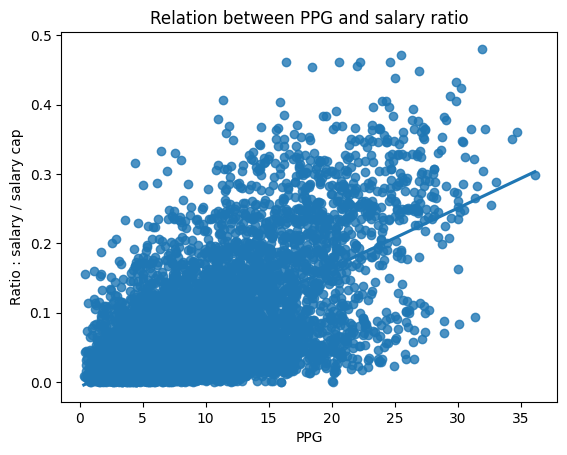

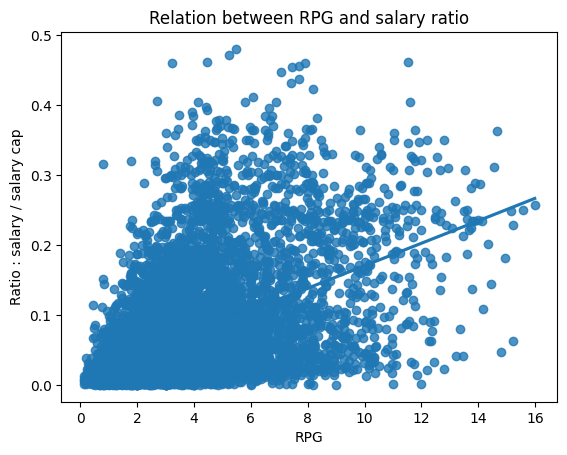

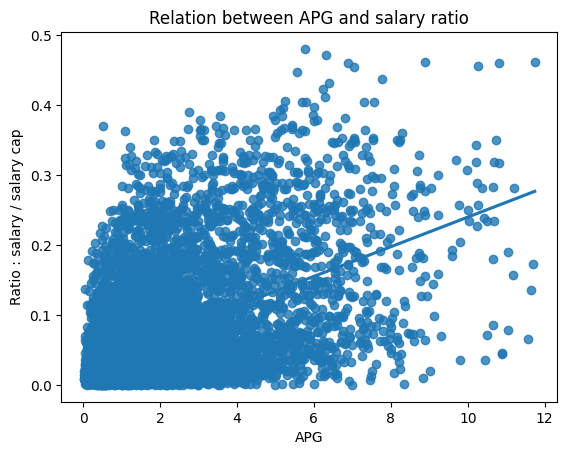

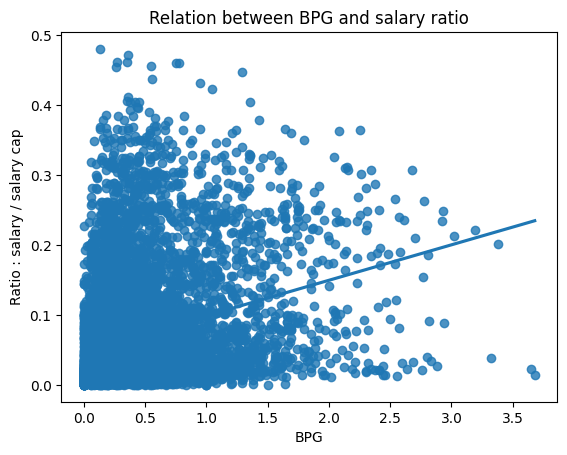

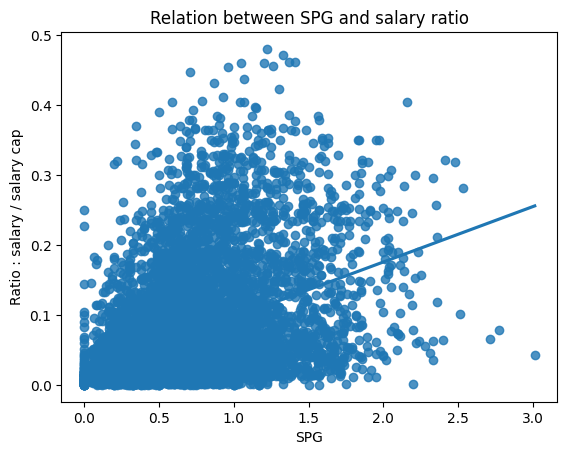

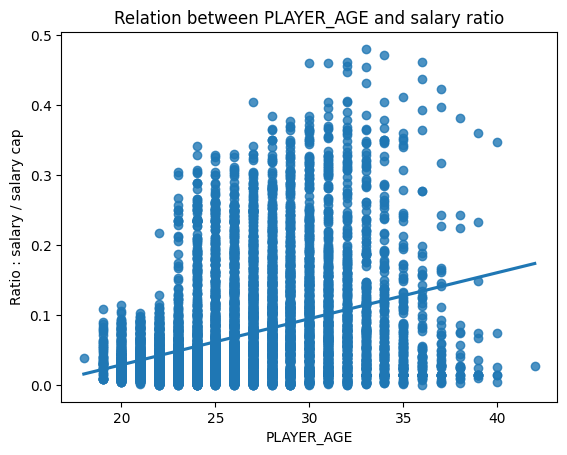

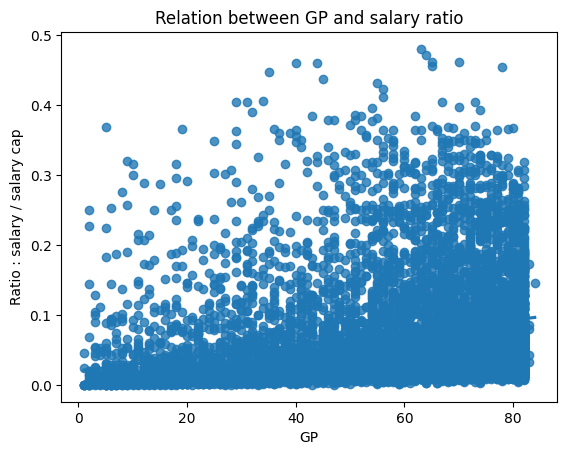

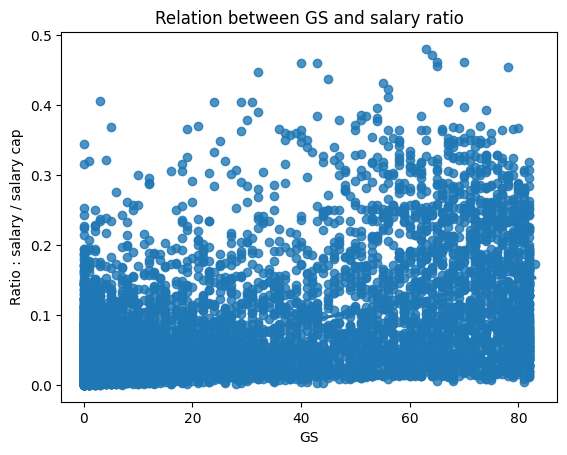

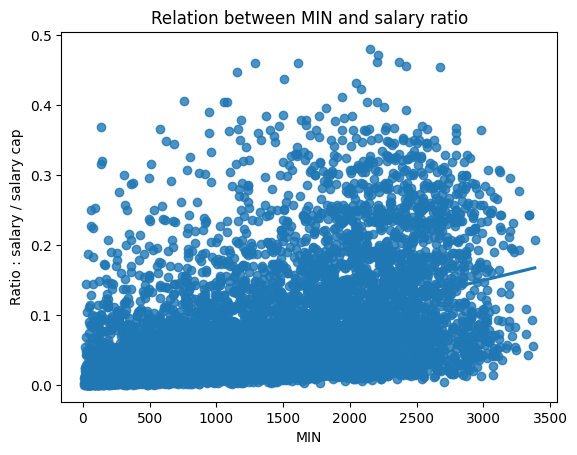

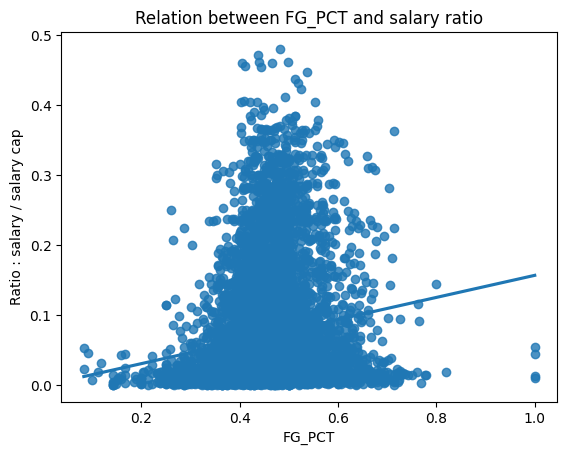

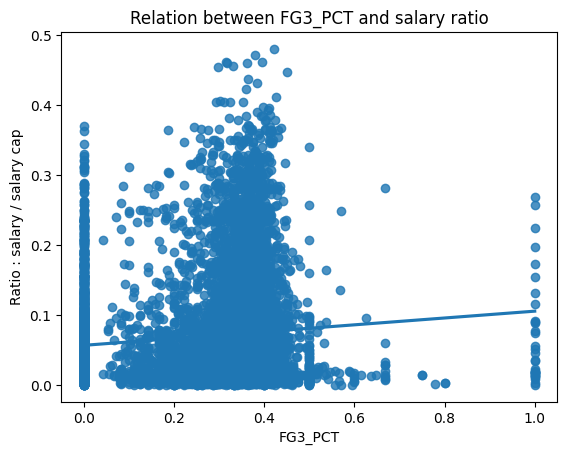

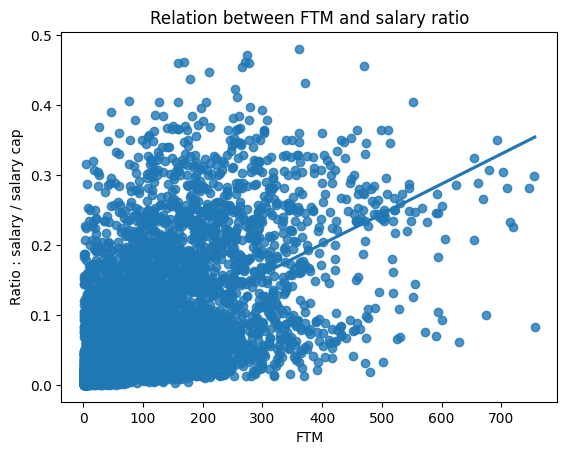

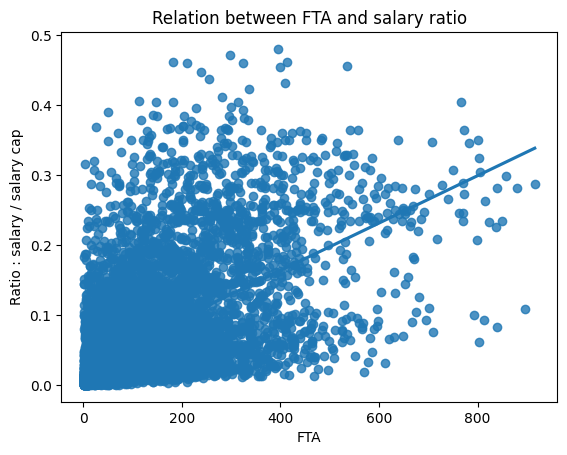

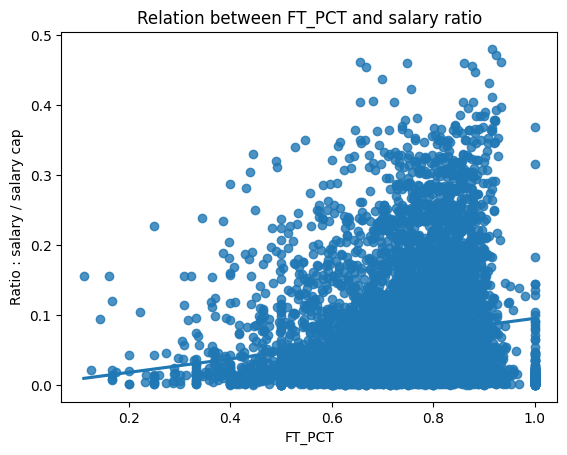

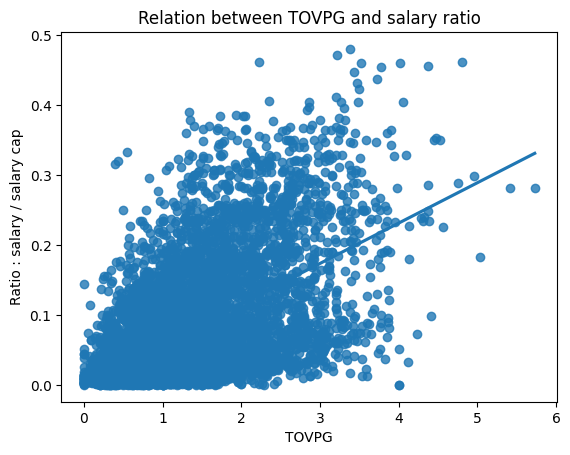

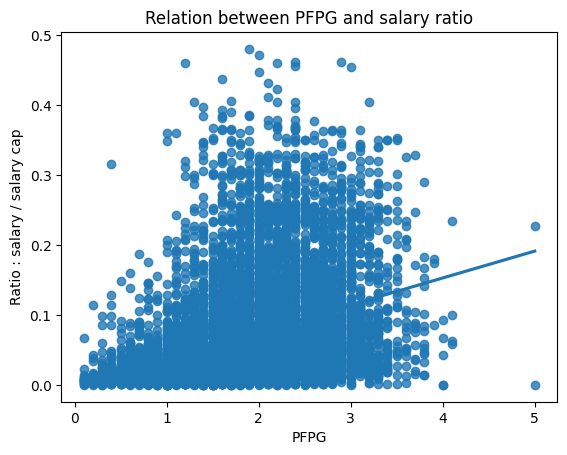

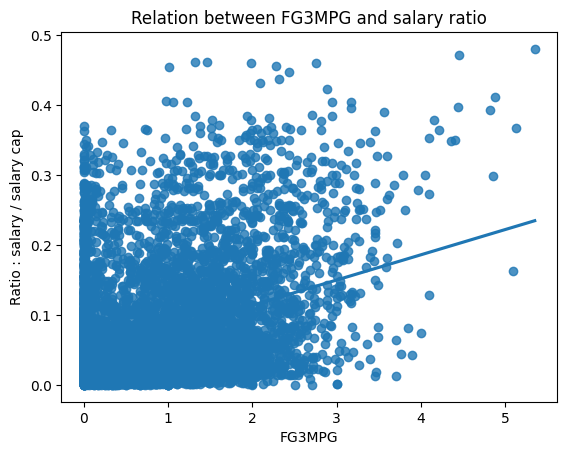

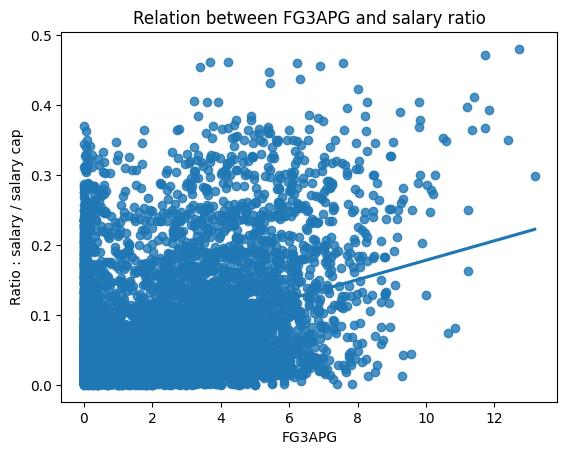

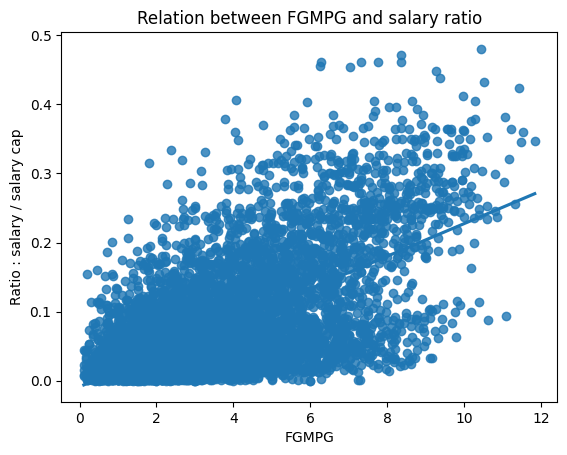

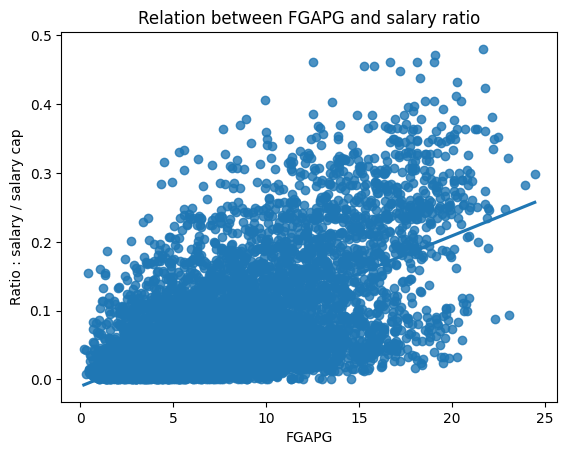

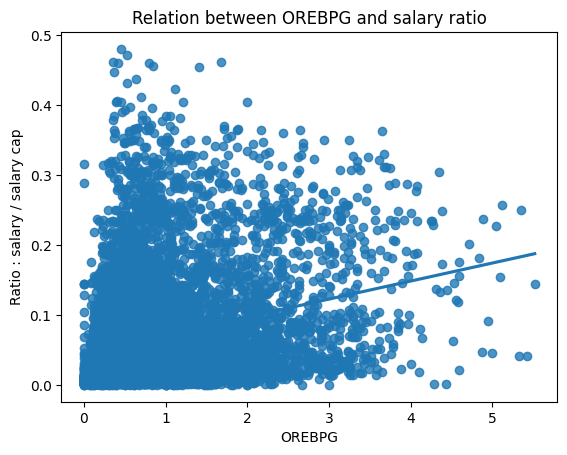

In [14]:
for elt in full_df.columns :
    if elt not in ['Player', 'SEASON_ID', 'TEAM_ABBREVIATION', 'ratio_cap']:
        sns.regplot(x=elt, y='ratio_cap', data=full_df, ci=None)  
        plt.xlabel(f'{elt}')
        plt.ylabel('Ratio : salary / salary cap')
        plt.title(f'Relation between {elt} and salary ratio')
        plt.show()

#### OLS Regression : General description of the dataset

In [15]:

X = full_df[['PPG']]          
X = sm.add_constant(X)    #  adding the constant for the intercept
y = full_df['ratio_cap']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ratio_cap   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     6205.
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:57:26   Log-Likelihood:                 11505.
No. Observations:                8145   AIC:                        -2.301e+04
Df Residuals:                    8143   BIC:                        -2.299e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0070      0.001     -5.991      0.0

#### Creation of the different sets

First, we initialize the gss1 spliter. We take 20% of our data for the test set (which will tell if our model is efficient) and 80% for the train set (to make the model work). The random_state = 42 is a seed that allows to reproduce the experience (or change it) if needed. 
gss1.split returns the indiex of the ligns that will be in the train set/test set.
test and trainval are the two different groups that we get off of the use of gss1.split.

gss2 is used to split the train set into training and validation sets. We take once again 20% of the train set to go into the validation set while the other 80% go for pure training. We change the seed at 43. We don't re-use gss1 so that there is a total independancy of the process between test, training and validation. We get train and val the same way we got test and trainval before. 

In [16]:
groups = full_df['Player']

gss1 = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42) # Test set (20%)
trainval_idx, test_idx = next(gss1.split(full_df, full_df['ratio_cap'], groups))
trainval = full_df.iloc[trainval_idx].reset_index(drop=True)
test = full_df.iloc[test_idx].reset_index(drop=True)

gss2 = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=43) # Validation set (16% tot)
train_idx, val_idx = next(gss2.split(trainval, trainval['ratio_cap'], trainval['Player']))
train = trainval.iloc[train_idx].reset_index(drop=True)
val = trainval.iloc[val_idx].reset_index(drop=True)

#### Pipelines and 1st model : Multi-Linear Regression

We use pipelines. They allow to chain the pre-treatment et the use of the modele in an automatic and concise way (We can use a same pipeline several times or adapt it partially depending on the model we use, in order to speed up and make the work homegenous).
num_proc works with numeric columns. SimpleImputer allows to insert the median value of a column if values are missing (what shouldn't be happening since we checked before but who knows...). Scaler transforms the variable value into its Z-score (z = (x - mean) / std). This helps for calculations.

cat_proc works in a seemingly way but with categorical variables.

preproc combines the 2 previous pipelines thanks to ColumnTransformer. num_proc applies to numeric columns (num_cols) and cat_proc to categoric columns (cat_cols).

In [17]:
features = [c for c in train.columns if c not in ['Player', 'SEASON_ID', 'ratio_cap']]
num_cols = train[features].select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in features if c not in num_cols]

num_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preproc = ColumnTransformer([
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])

lin_pipe = Pipeline([
    ('preproc', preproc),
    ('model', LinearRegression())
])

In [18]:
lin_pipe.fit(train[features], train['ratio_cap'])
y_test_pred = lin_pipe.predict(test[features])

r2 = r2_score(test['ratio_cap'], y_test_pred)
print("R² test :", r2)

n = test.shape[0]
p = len(features)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("adjusted R² test :", r2_adj)

R² test : 0.5762398784771572
adjusted R² test : 0.5707720059413786


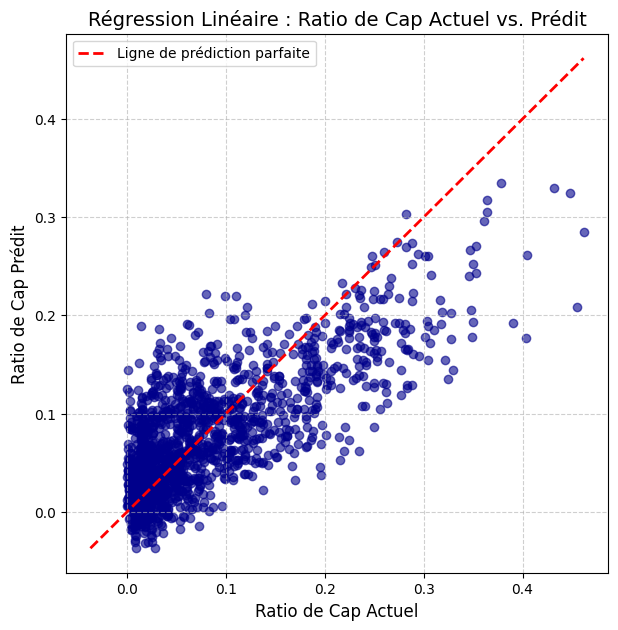

In [19]:
y_true = test['ratio_cap']
min_val = min(y_true.min(), y_test_pred.min())
max_val = max(y_true.max(), y_test_pred.max())
plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_test_pred, alpha=0.6, color='darkblue')
plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', color='red', linewidth=2, label='Ligne de prédiction parfaite')
plt.title('Régression Linéaire : Ratio de Cap Actuel vs. Prédit', fontsize=14)
plt.xlabel('Ratio de Cap Actuel', fontsize=12)
plt.ylabel('Ratio de Cap Prédit', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

We can see that our multi linear model has a 0.57 R². This shows that "Our model can explain 57% of the results".
While this is an interesting, we want to try other models (linear or not) to see how they performed against the reference of the multi-linear regression.

#### 2nd model : Ridge

Right before, we worked with the multi-linear regression model. 
We could have stopped there since the objective is to use a multi-linear regression model. However, we want to test other models to see how they perform and to learn more about how to use them.

The pipeline contains the ridge model. It is a multi-linear regression associated to a regularisation function with squared terms. The regularisation function is a cost function that must be minimized (it has the form of : sum of lambda{i} alpha{i}^2). This is very useful in our case since we have a huge amount of statistics for NBA players. The ridge model allows us to minimize the less important parameters. The Lasso model is a variant of the Ridge model who can nullify the "not very useful" parameters while the Ridge model can't make their weight equal to 0 in the final model. We prefer to use the Ridge first but we will test the Lasso later (and other models to compare each one of them).

In [20]:
ridge = Ridge(alpha=1.0) 
pipe = Pipeline([
    ('preproc', preproc),
    ('model', ridge)
])

First, we initialize a GroupKFold with 5 subsets. We prefered the GroupKFold method over a classic KFold since making groups is relevant in our case. This way, all the seasons of a same player are all in the same subset, avoiding a "data leakage" between train set and test set. Let's take the example of Lebron James. All of his seasons (all the ligns having "Lebron James" in the Player column) will be either in the test set or the training set and in the same subset (meaning we can't have Lebron James both in the train set and the validation set). The only inconvenient is that the result is a less randomized process than with KFold since we form groups. So GroupKFold means having a little higher variance but it avoids data leakage and gives more meaning to each subset (each one contains different players). 

Next, groups_train indicates which subset each player belongs to.

alphas is a dictionary representing the hyperparameter grid for GridSearchCV. The values of alpha are the regularization parameters for ridge regression.

GridSearchCV takes as arguments alphas, the evaluation method (mean absolute error), and the features/labels from the training group organized with gfk. The goal is to test the model with all the different alpha hyperparameters. They are then evaluated according to the chosen evaluation method. The alpha that minimizes the scoring is kept.
For example, if we used the KNN method, GridSearchCV would allow us to determine the optimal number of neighbors to use for the best possible prediction.

In [21]:
gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

# GridSearch pour ajuster alpha (régularisation) sur le train set
alphas = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(pipe, param_grid=alphas, scoring='neg_mean_absolute_error', cv=gkf.split(train[features], train['ratio_cap'], groups_train))
gs.fit(train[features], train['ratio_cap'])

print("Meilleur alpha:", gs.best_params_)
model_fitted = gs.best_estimator_.named_steps['model']  # extrait l'objet Ridge
pipe = gs.best_estimator_
preproc_fitted = pipe.named_steps['preproc']
model_fitted = pipe.named_steps['model']  # si tu n'utilises pas MultiOutputRegressor


feature_names = preproc_fitted.get_feature_names_out()
for name, coef in zip(feature_names, model_fitted.coef_):
    print(f"{name}: {coef}")
print("Intercept :", model_fitted.intercept_)

print("CV Score (MAE):", -gs.best_score_)

Meilleur alpha: {'model__alpha': 100}
num__PPG: 0.02100371714742975
num__RPG: 0.020299548522646815
num__APG: 0.007004513656375959
num__BPG: 0.005237525191359017
num__SPG: -0.003935825401178846
num__PLAYER_AGE: 0.02388112561222481
num__GP: -0.0005802060367863011
num__GS: 0.012371084049245747
num__MIN: -0.012958645736167904
num__FG_PCT: -0.0025478353715998165
num__FG3_PCT: -0.004551543666040481
num__FTM: 0.0023182027468926997
num__FTA: 0.0025625310543635174
num__FT_PCT: -0.002820362243155037
num__TOVPG: 0.003258958447104876
num__PFPG: -0.007532293177274757
num__FG3MPG: 0.006403490074027739
num__FG3APG: -0.0035234215637349807
num__FGMPG: 0.013467072415561082
num__FGAPG: 0.0009364366571741807
num__OREBPG: -0.0079344907297875
cat__TEAM_ABBREVIATION_ATL: 0.003356231606364173
cat__TEAM_ABBREVIATION_BKN: -0.000858605209447744
cat__TEAM_ABBREVIATION_BOS: 0.0038021043883828026
cat__TEAM_ABBREVIATION_CHA: -0.0008642926268825674
cat__TEAM_ABBREVIATION_CHH: -0.00024481937803255547
cat__TEAM_ABBREVI

In [22]:
val_preds = gs.predict(val[features])
mae_val = mean_absolute_error(val['ratio_cap'], val_preds)
print(f"MAE validation set : {mae_val:.4f}")
r2 = r2_score(val['ratio_cap'], val_preds)
print("validation R² Ridge :", r2)
n = val.shape[0]      
p = val.shape[1]       
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("validation adjusted R² :", r2_adj)

MAE validation set : 0.0359
validation R² Ridge : 0.5940102815027279
validation adjusted R² : 0.5856220641784041


In [23]:
trainval = pd.concat([train, val]).reset_index(drop=True)
pipe_best = Pipeline([
    ('preproc', preproc),
    ('model', Ridge(alpha=gs.best_params_['model__alpha']))
])
pipe_best.fit(trainval[features], trainval['ratio_cap'])
test_preds = pipe_best.predict(test[features])
mae_test = mean_absolute_error(test['ratio_cap'], test_preds)
print("MAE Validation:", mean_absolute_error(val['ratio_cap'], val_preds))
print(f"MAE test set : {mae_test:.4f}")
moy = test['ratio_cap'].mean()
err_moy = mean_absolute_error(test['ratio_cap'], test_preds)
print("Mean:", moy,"\nMean error:", err_moy)
r2 = r2_score(test['ratio_cap'], test_preds)
print("R² Ridge test :", r2)
n = test.shape[0]       # nombre de lignes (échantillons)
p = test.shape[1]       # nombre de colonnes (features)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("adjusted R² test:", r2_adj)

MAE Validation: 0.03589475929394604
MAE test set : 0.0388
Mean: 0.07407815773396603 
Mean error: 0.038822639455446326
R² Ridge test : 0.5766993749820917
adjusted R² test: 0.5704816807250719


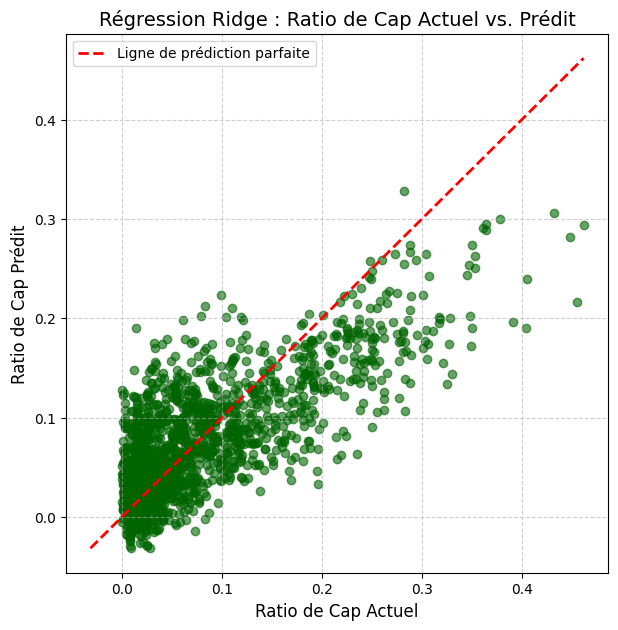

In [24]:
y_true = test['ratio_cap']

min_val = min(y_true.min(), test_preds.min())
max_val = max(y_true.max(), test_preds.max())

plt.figure(figsize=(7, 7))

plt.scatter(y_true, test_preds, alpha=0.6, color='darkgreen')

plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', color='red', linewidth=2, label='Ligne de prédiction parfaite')

plt.title('Régression Ridge : Ratio de Cap Actuel vs. Prédit', fontsize=14)
plt.xlabel('Ratio de Cap Actuel', fontsize=12)
plt.ylabel('Ratio de Cap Prédit', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

We get a Mean Absolute Error of 0,0391 on the prediction. This is near from the same error as with the validation set. The model is not overfitting.
The R² is also around 0.57 so it's comparable to the classic multi-linear regression.

#### 3rd Model : Lasso

Now, we want to focus on a more strict model : the Lasso. It's also a multi-linear regression but it can nullify some parameters thanks to the cost function that's added to the multi-linear part.

In [25]:
lasso = Lasso(max_iter=10000) 
pipe_l = Pipeline([
    ('preproc', preproc),
    ('model', lasso)
])
alphas = {'model__alpha': [0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10, 30, 100]}
gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

gs = GridSearchCV(pipe_l, param_grid=alphas,
                  scoring='neg_mean_absolute_error',
                  cv=gkf.split(train[features], train['ratio_cap'], groups_train))
gs.fit(train[features], train['ratio_cap'])

print("Best alpha:", gs.best_params_)
print("CV Score (MAE):", -gs.best_score_)

Best alpha: {'model__alpha': 0.0005}
CV Score (MAE): 0.0377581187309207


In [26]:
lasso_fitted = gs.best_estimator_.named_steps['model']
preproc_fitted = gs.best_estimator_.named_steps['preproc']
feature_names = preproc_fitted.get_feature_names_out()

for name, coef in zip(feature_names, lasso_fitted.coef_):
    print(f"{name}: {coef}")

num__PPG: 0.04012020320232169
num__RPG: 0.017493390750612663
num__APG: 0.006564885155950387
num__BPG: 0.004326761046602169
num__SPG: -0.0030024941646467312
num__PLAYER_AGE: 0.02377209583428434
num__GP: -0.0008850567497649329
num__GS: 0.010894588522010683
num__MIN: -0.008702598565436127
num__FG_PCT: -0.0018831803815604565
num__FG3_PCT: -0.003901002854029449
num__FTM: 0.0
num__FTA: 0.0
num__FT_PCT: -0.00253520448640468
num__TOVPG: 0.00199734742389767
num__PFPG: -0.007053854632374701
num__FG3MPG: 0.0
num__FG3APG: -0.0
num__FGMPG: 0.0
num__FGAPG: 0.0
num__OREBPG: -0.0049820279450236106
cat__TEAM_ABBREVIATION_ATL: 0.0
cat__TEAM_ABBREVIATION_BKN: -0.0
cat__TEAM_ABBREVIATION_BOS: 0.0
cat__TEAM_ABBREVIATION_CHA: -0.0
cat__TEAM_ABBREVIATION_CHH: -0.0
cat__TEAM_ABBREVIATION_CHI: 0.0
cat__TEAM_ABBREVIATION_CLE: -0.0
cat__TEAM_ABBREVIATION_DAL: -0.0
cat__TEAM_ABBREVIATION_DEN: 0.0
cat__TEAM_ABBREVIATION_DET: 0.0
cat__TEAM_ABBREVIATION_GSW: 0.0
cat__TEAM_ABBREVIATION_HOU: -0.0
cat__TEAM_ABBREVIATIO

We can see that it's been interesting to use the Lasso after the ridge because an mportant of the parameters were nullified by the model. With the Lasso we get rid of the team the player is in as well as the stats related to the number of shots scored and attempted.

This phenomenon seems coherent. For the team, they sure have each one of them specifities that could let us think that they are an important parameter. But, from 2000 to 2025, each team (approximately) went to different stages (in terms of competitiveness in the league) with the need to use all the salary cap (or even more) to pay the players and years where teams have low competitiveness and don't need to use the whole salary cap (in order to save money).

For the shots attemps/scored, we can explain that the Lasso doesn't take them into account because they are kind of related to the PPG statistic which is the most highly coefficiented in the model.

In [27]:
val_preds = gs.predict(val[features])
test_preds = gs.predict(test[features])
print("MAE Validation:", mean_absolute_error(val['ratio_cap'], val_preds))
print("MAE Test:", mean_absolute_error(test['ratio_cap'], test_preds))
r2_lasso = r2_score(val['ratio_cap'], val_preds)
print("R² Lasso :", r2)
n = test.shape[0]       # nombre de lignes (échantillons)
p = test.shape[1]       # nombre de colonnes (features)
r2_adj = 1 - (1 - r2_lasso) * (n - 1) / (n - p - 1)
print("adjusted R² :", r2_adj)
moy = test['ratio_cap'].mean()
err_moy = mean_absolute_error(test['ratio_cap'], test_preds)
print("mean :",moy, "\nmean error:",err_moy)

MAE Validation: 0.03588415633936035
MAE Test: 0.038870637214171326
R² Lasso : 0.5766993749820917
adjusted R² : 0.591295174167441
mean : 0.07407815773396603 
mean error: 0.038870637214171326


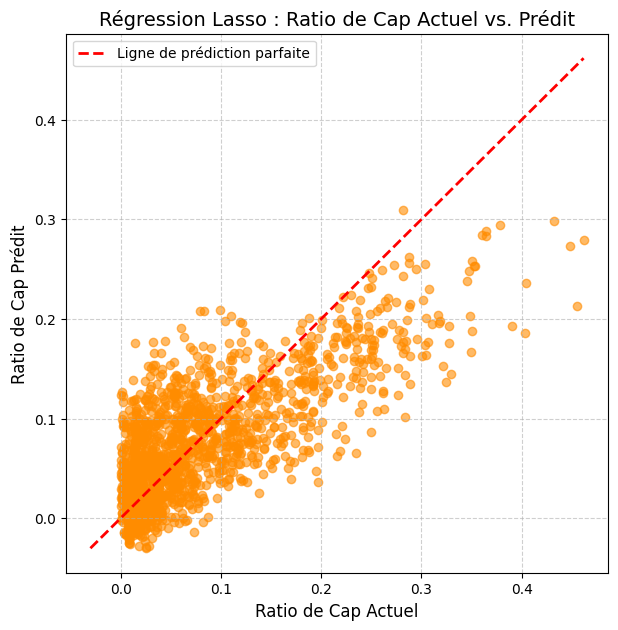

In [28]:
y_true = test['ratio_cap']

min_val = min(y_true.min(), test_preds.min())
max_val = max(y_true.max(), test_preds.max())

plt.figure(figsize=(7, 7))

plt.scatter(y_true, test_preds, alpha=0.6, color='darkorange')

plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', color='red', linewidth=2, label='Ligne de prédiction parfaite')

plt.title('Régression Lasso : Ratio de Cap Actuel vs. Prédit', fontsize=14)
plt.xlabel('Ratio de Cap Actuel', fontsize=12)
plt.ylabel('Ratio de Cap Prédit', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Looking at the R² coefficient, we get a better result with the Lasso so we could be tempted to use this model to predict salaries (for now)

#### 4th Model : Decision Tree Regressor

Now we want to test a non-linear model to see if it performs better than the previous 3. We will first use DecisionTreeRegressor

In [29]:
tree = DecisionTreeRegressor(random_state=42)
pipe_t = Pipeline([
    ('preproc', preproc),
    ('model', tree)])
param_grid = {'model__max_depth': [3, 5, 7, 10, 15, None]}
gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

gs = GridSearchCV(pipe_t, param_grid=param_grid,
                  cv=gkf.split(train[features], train['ratio_cap'], groups_train),
                  scoring='neg_mean_absolute_error')
gs.fit(train[features], train['ratio_cap'])

print("Best max_depth :", gs.best_params_["model__max_depth"])
print("CV Score (MAE):", -gs.best_score_)

Best max_depth : 5
CV Score (MAE): 0.034453502695165394


In [30]:
best_tree = gs.best_estimator_.named_steps['model']
preproc_fitted = gs.best_estimator_.named_steps['preproc']
feature_names = preproc_fitted.get_feature_names_out()

importances = best_tree.feature_importances_
for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")

num__PPG: 0.4845
num__PLAYER_AGE: 0.2589
num__FGMPG: 0.1487
num__RPG: 0.0342
num__GS: 0.0163
num__TOVPG: 0.0114
num__FGAPG: 0.0076
num__BPG: 0.0068
num__FT_PCT: 0.0061
num__APG: 0.0060
num__FG_PCT: 0.0060
num__FG3MPG: 0.0048
num__OREBPG: 0.0047
num__MIN: 0.0040
num__SPG: 0.0000
num__GP: 0.0000
num__FG3_PCT: 0.0000
num__FTM: 0.0000
num__FTA: 0.0000
num__PFPG: 0.0000
num__FG3APG: 0.0000
cat__TEAM_ABBREVIATION_ATL: 0.0000
cat__TEAM_ABBREVIATION_BKN: 0.0000
cat__TEAM_ABBREVIATION_BOS: 0.0000
cat__TEAM_ABBREVIATION_CHA: 0.0000
cat__TEAM_ABBREVIATION_CHH: 0.0000
cat__TEAM_ABBREVIATION_CHI: 0.0000
cat__TEAM_ABBREVIATION_CLE: 0.0000
cat__TEAM_ABBREVIATION_DAL: 0.0000
cat__TEAM_ABBREVIATION_DEN: 0.0000
cat__TEAM_ABBREVIATION_DET: 0.0000
cat__TEAM_ABBREVIATION_GSW: 0.0000
cat__TEAM_ABBREVIATION_HOU: 0.0000
cat__TEAM_ABBREVIATION_IND: 0.0000
cat__TEAM_ABBREVIATION_LAC: 0.0000
cat__TEAM_ABBREVIATION_LAL: 0.0000
cat__TEAM_ABBREVIATION_MEM: 0.0000
cat__TEAM_ABBREVIATION_MIA: 0.0000
cat__TEAM_ABBREVI

In [31]:
val_preds_tree = gs.predict(val[features])
test_preds_tree = gs.predict(test[features])
print("MAE Validation:", mean_absolute_error(val['ratio_cap'], val_preds_tree))
print("MAE Test:", mean_absolute_error(test['ratio_cap'], test_preds_tree))
r2 = r2_score(test['ratio_cap'], test_preds_tree)
print("R2 Test Tree :", r2)
n = test.shape[0]       # nombre de lignes (échantillons)
p = test.shape[1]       # nombre de colonnes (features)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R² :", r2_adj)

MAE Validation: 0.03262109216012211
MAE Test: 0.036006441754998265
R2 Test Tree : 0.5768456387064431
Adjusted R² : 0.5706300928590055


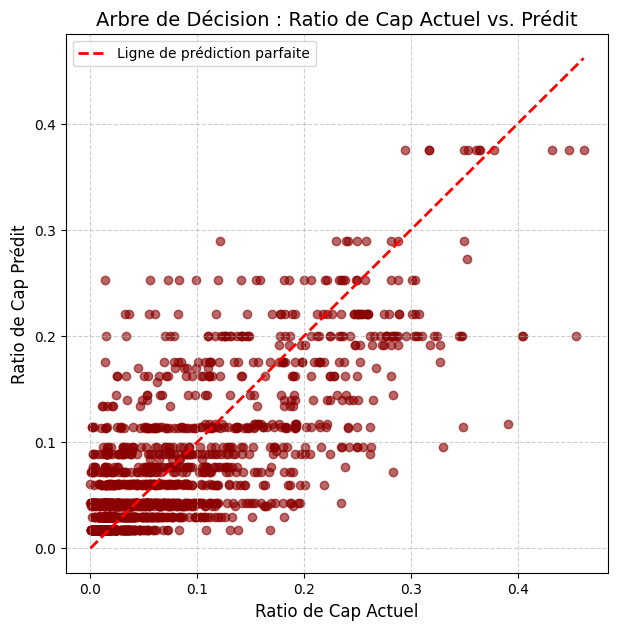

In [32]:
y_true = test['ratio_cap']

min_val = min(y_true.min(), test_preds_tree.min())
max_val = max(y_true.max(), test_preds_tree.max())

plt.figure(figsize=(7, 7))

plt.scatter(y_true, test_preds_tree, alpha=0.6, color='darkred')

plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', color='red', linewidth=2, label='Ligne de prédiction parfaite')

plt.title('Arbre de Décision : Ratio de Cap Actuel vs. Prédit', fontsize=14)
plt.xlabel('Ratio de Cap Actuel', fontsize=12)
plt.ylabel('Ratio de Cap Prédit', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

We get a good result with the decision tree regressor compared to the multi-linear models.

We could be tempted to chose this model instinctively but the "explainability" is a bit less easy to understand than with a multi-linear model in which you can say "the coefficient PPG is ponderated of this much so when PPG goes up by XXX, salary goes up by YYY".

The adjusted R² is 0.57 what can look bad. But when looking at the work of other people (professionals ?) (https://towardsdatascience.com/predicting-nba-salaries-with-machine-learning-ed68b6f75566/), we can estimate that it's at least ok.

#### 5th Model : SVR

In [33]:
svr = SVR(kernel='rbf')  # kernel RBF par défaut, non linéaire

pipe_svr = Pipeline([
    ('preproc', preproc),
    ('model', svr)
])


In [34]:
param_grid = {
    'model__C': [0.01, 0.1, 0.15],
    'model__epsilon': [0.01, 0.05, 0.1],
    'model__gamma': ['scale', 'auto']  
}

gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

gs_svr = GridSearchCV(
    pipe_svr,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=gkf.split(train[features], train['ratio_cap'], groups_train),
    n_jobs=-1
)

gs_svr.fit(train[features], train['ratio_cap'])

print("Best hyperparameters SVR :", gs_svr.best_params_)
print("MAE CV (mean) :", -gs_svr.best_score_)

Best hyperparameters SVR : {'model__C': 0.1, 'model__epsilon': 0.01, 'model__gamma': 'auto'}
MAE CV (mean) : 0.03137263151824733


In [35]:
y_val_pred = gs_svr.predict(val[features])
mae_val = mean_absolute_error(val['ratio_cap'], val_preds)
print("MAE validation SVR :", mae_val)

# Test
y_test_pred_svr = gs_svr.predict(test[features])
mae_test = mean_absolute_error(test['ratio_cap'], y_test_pred_svr)
from sklearn.metrics import r2_score
r2_test = r2_score(test['ratio_cap'], y_test_pred_svr)
print("MAE SVR test :", mae_test)
print("R² SVR test  :", r2_test)
n = test.shape[0]       # nombre de lignes (échantillons)
p = test.shape[1]       # nombre de colonnes (features)
r2_adj = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)
print("Adjusted R²:", r2_adj)

MAE validation SVR : 0.03588415633936035
MAE SVR test : 0.032692148162435555
R² SVR test  : 0.6411056927446448
Adjusted R²: 0.6358340372326683


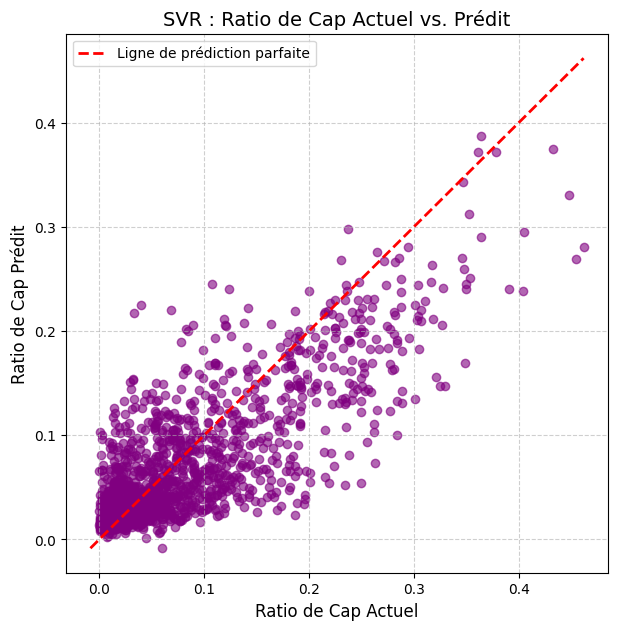

In [36]:
y_true = test['ratio_cap']

min_val = min(y_true.min(), y_test_pred_svr.min())
max_val = max(y_true.max(), y_test_pred_svr.max())

plt.figure(figsize=(7, 7))

plt.scatter(y_true, y_test_pred_svr, alpha=0.6, color='purple')

plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', color='red', linewidth=2, label='Ligne de prédiction parfaite')

plt.title('SVR : Ratio de Cap Actuel vs. Prédit', fontsize=14)
plt.xlabel('Ratio de Cap Actuel', fontsize=12)
plt.ylabel('Ratio de Cap Prédit', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

The result is very positive ! We get a R² of 0.636

It is as good or even better than the results obtained in this article (depending on if the author displays the R or R²: https://towardsdatascience.com/predicting-nba-salaries-with-machine-learning-ed68b6f75566/)

However, compared to the multi-linear models, the SVR model (especially with rbf kernel) is not appropriate for explainability since it is a complex non-linear model.

# 6th Model : Random Forest

In this sixth model, we use a Random Forest Regressor.
It combines many decision trees to capture non-linear patterns in the data, while reducing overfitting by averaging their results.

In [37]:

rf = RandomForestRegressor(random_state=42)

pipe_rf = Pipeline([
    ('preproc', preproc),
    ('model', rf)
])


param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

gkf = GroupKFold(n_splits=5)
groups_train = train['Player']
gs_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf,
 scoring='neg_mean_absolute_error',
 cv=gkf.split(train[features], train['ratio_cap'], groups_train),
 n_jobs=-1) 

gs_rf.fit(train[features], train['ratio_cap'])

print("Best params:", gs_rf.best_params_)
print("CV Score (MAE):", -gs_rf.best_score_)

Best params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 300}
CV Score (MAE): 0.031841198022783755


In [38]:
best_rf = gs_rf.best_estimator_

#Test
y_test_pred_rf = best_rf.predict(test[features])
mae_rf = mean_absolute_error(test['ratio_cap'], y_test_pred_rf)
r2_rf = r2_score(test['ratio_cap'], y_test_pred_rf)
print("MAE Random Forest test :", mae_rf)
print("R² Random Forest test  :", r2_rf)
n = test.shape[0]       # nombre de lignes (échantillons)
p = len(features)       # nombre de colonnes (features)
r2_adj_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)
print("Adjusted R²:", r2_adj_rf)

MAE Random Forest test : 0.032345284714860006
R² Random Forest test  : 0.6596878401364954
Adjusted R²: 0.6552967154930953


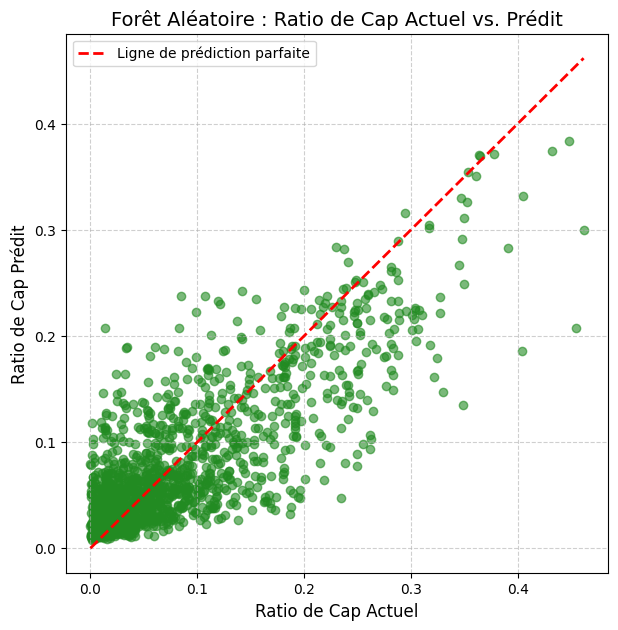

In [39]:
y_true = test['ratio_cap']

min_val = min(y_true.min(), y_test_pred_rf.min())
max_val = max(y_true.max(), y_test_pred_rf.max())

plt.figure(figsize=(7, 7))

plt.scatter(y_true, y_test_pred_rf, alpha=0.6, color='forestgreen')

plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', color='red', linewidth=2, label='Ligne de prédiction parfaite')

plt.title('Forêt Aléatoire : Ratio de Cap Actuel vs. Prédit', fontsize=14)
plt.xlabel('Ratio de Cap Actuel', fontsize=12)
plt.ylabel('Ratio de Cap Prédit', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

The result is excellent. We get an R² of 0.66. It is the best score obtained so far, surpassing the performance of the SVR model (R² =0.636) and significantly outperforming the multi-linear models (R² = 0.57).

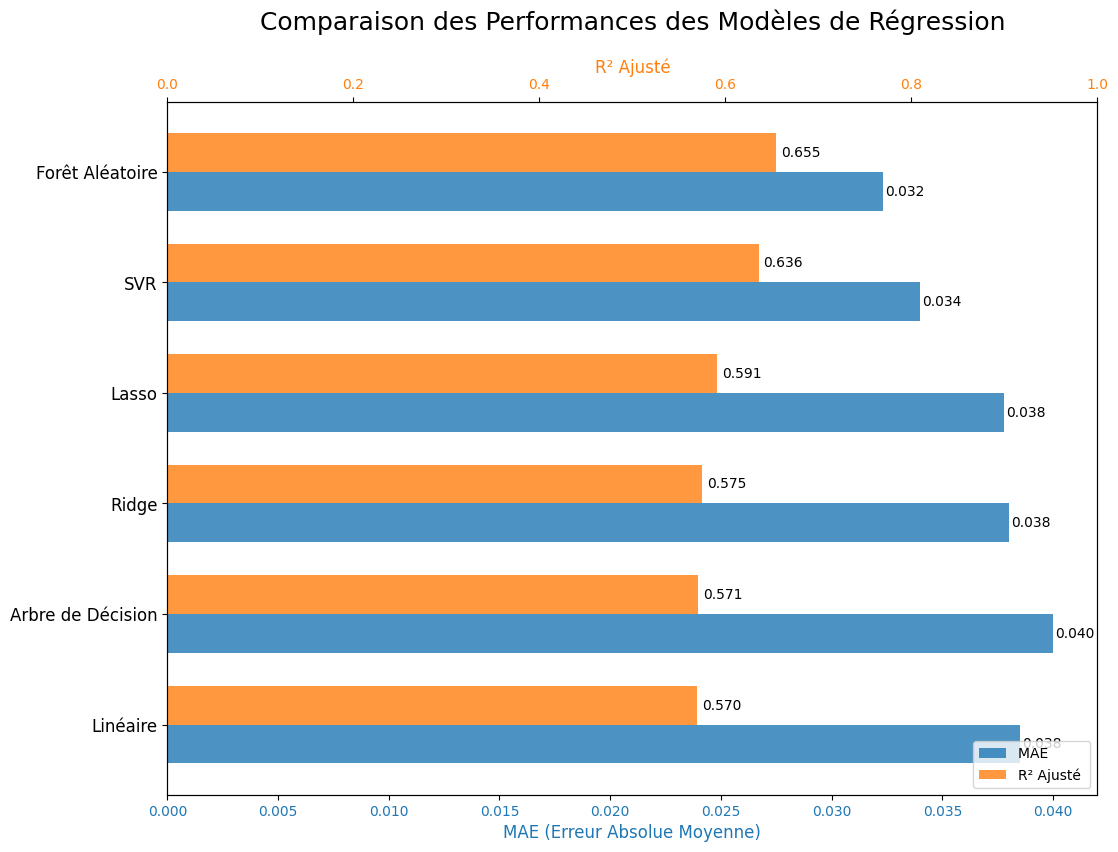

In [40]:
data = {
    'Modèle': ['Linéaire', 'Ridge', 'Lasso', 'Arbre de Décision', 'SVR', 'Forêt Aléatoire'],
    'R² Ajusté': [0.570, 0.575, 0.591, 0.571, 0.636, 0.655], 
    'MAE': [0.0385, 0.0380, 0.0378, 0.0400, 0.0340, 0.0323] 
}
df_metrics = pd.DataFrame(data)
df_metrics = df_metrics.sort_values(by='R² Ajusté', ascending=False)

labels = df_metrics['Modèle']
r2_adj = df_metrics['R² Ajusté']
mae = df_metrics['MAE']

x = np.arange(len(labels))  
width = 0.35  

fig, ax1 = plt.subplots(figsize=(12, 9)) 

rects1 = ax1.barh(x + width/2, mae, width, label='MAE ', color='#1f77b4', alpha=0.8)
ax1.set_xlabel('MAE (Erreur Absolue Moyenne)', fontsize=12, color='#1f77b4')
ax1.tick_params(axis='x', labelcolor='#1f77b4')


ax2 = ax1.twiny() 
rects2 = ax2.barh(x - width/2, r2_adj, width, label='R² Ajusté ', color='#ff7f0e', alpha=0.8)
ax2.set_xlabel('R² Ajusté', fontsize=12, color='#ff7f0e')
ax2.tick_params(axis='x', labelcolor='#ff7f0e')
ax2.set_xlim(0, 1) 


ax1.set_yticks(x)
ax1.set_yticklabels(labels, fontsize=12)
ax1.invert_yaxis()  


ax1.set_title('Comparaison des Performances des Modèles de Régression', fontsize=18, pad=20) 
ax1.legend(loc='lower right', handles=[rects1, rects2])


for rects in [rects1, rects2]:
    target_ax = ax2 if rects == rects2 else ax1
    for rect in rects:
        width_val = rect.get_width()
        target_ax.text(width_val + 0.005 if rects == rects2 else width_val + 0.0001,
                 rect.get_y() + rect.get_height()/2,
                 f'{width_val:.3f}',
                 ha='left', va='center', fontsize=10)



plt.savefig("mon_plot.png") 
plt.show()

The conclusion is that we can make our choice between 2 models : The random Forest, which has the best performance but doesn't have a good explainability and the Lasso who has a less good performance but is the most performing model among the multi-linear ones, which have a better explainability. 

So, the choice of models will depend on the client's needs : explainability or pure performance.